In [30]:
import pandas as pd
import numpy as np

In [31]:
data = pd.read_csv("train_v9rqX0R.csv")

In [32]:
data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [33]:
#understanding categorical col

print(data["Item_Fat_Content"].unique())
print(data["Item_Type"].unique())
print(data["Outlet_Size"].unique())
print(data["Outlet_Location_Type"].unique())
print(data["Outlet_Type"].unique())

['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
['Medium' nan 'High' 'Small']
['Tier 1' 'Tier 3' 'Tier 2']
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


In [34]:
#handling categorical col
def normalize_content(data):
    replace_map={
    'low fat' : 'Low Fat',
    'lf': 'Low Fat',
    'reg':'Regular',
    'LF': 'Low Fat',
    'Low fat': 'Low Fat'
    }
    data['Item_Fat_Content'] = data['Item_Fat_Content'].replace(replace_map)
    return data

data = normalize_content(data)

   
print(data['Item_Fat_Content'].unique())
print(data['Outlet_Size'].unique())

['Low Fat' 'Regular']
['Medium' nan 'High' 'Small']


In [35]:
#train test split
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Item_Outlet_Sales'])
Y = data['Item_Outlet_Sales']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=43)


In [36]:
#applying one hot encoding
#data_ohe = pd.get_dummies(data[cat_col])
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer


cat_col = X_train.select_dtypes(include=['object','category']).columns
num_cols = X_train.select_dtypes(include=["number"]).columns

preprocessor = ColumnTransformer(
    transformers=[
    ('num', Pipeline([("imputer", SimpleImputer(strategy = "median")),
                      ("scaler", StandardScaler())]), num_cols),
    ('cat', Pipeline([("imputer", SimpleImputer(strategy = "most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown='ignore',sparse_output=False))]), cat_col),
])


In [70]:
# model fitting
from sklearn.compose import TransformedTargetRegressor

lr = LinearRegression()
lr = Pipeline(steps=[
    ('preprocessor' ,preprocessor),
    ('regressor' ,LinearRegression())
])

log_lr = TransformedTargetRegressor(
    regressor=lr,
    func=np.log1p,        # transform y -> log(1+y)
    inverse_func=np.expm1 # invert back to original scale
)


log_lr.fit(X_train, Y_train)
Y_pred = log_lr.predict(X_test)


In [71]:
#check performance -> rmse
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print(rmse)

1225.414196105145


In [75]:
#test data
test_data = pd.read_csv("test_AbJTz2l.csv")
test_data = normalize_content(test_data)
predict = log_lr.predict(test_data)
selected_inputs = test_data[['Item_Identifier', 'Outlet_Identifier']]
output_df = selected_inputs.copy()
output_df['Item_Outlet_Sales'] = predict

In [76]:
#file with predicted target value
output_df.to_csv('predictions_output.csv', index=False)

In [44]:
# percentage of negative values
neg_count = np.sum(predict < 0)
total = len(predict)

print(f"Negative predictions: {neg_count} out of {total} ({neg_count/total:.2%})")

Negative predictions: 337 out of 5681 (5.93%)


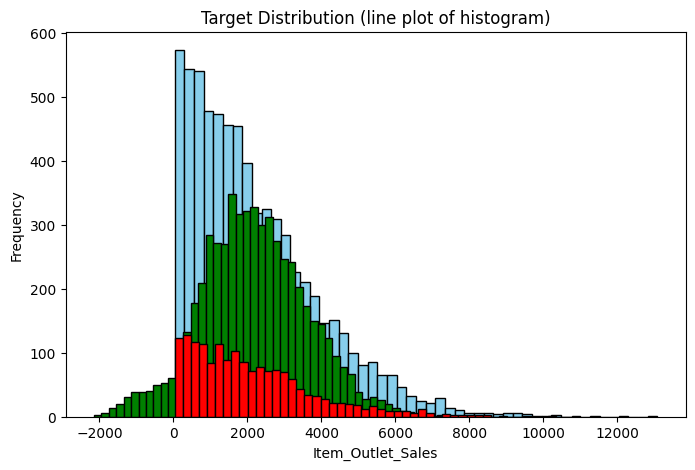

In [69]:
#plotting graph to compare outputs

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.hist(Y_train, bins=50, color="skyblue", edgecolor="k")
plt.hist(predict, bins=50, color="green", edgecolor="k")
plt.hist(Y_test, bins=50, color="red", edgecolor="k")

plt.title("Target Distribution (line plot of histogram)")
plt.xlabel("Item_Outlet_Sales")
plt.ylabel("Frequency")
plt.show()

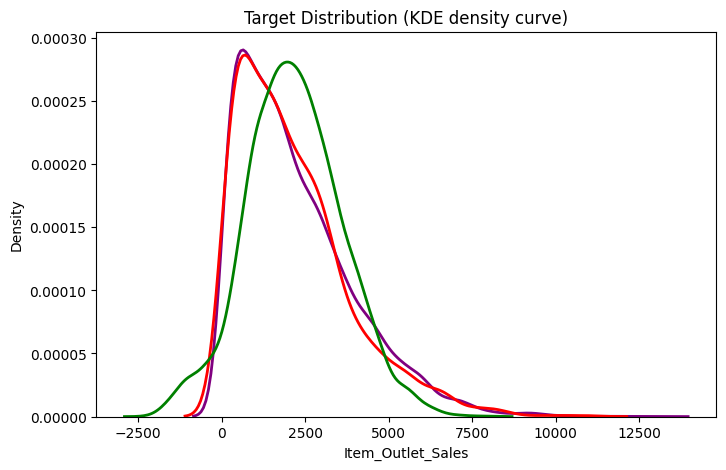

In [66]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.kdeplot(Y_train, color="purple", lw=2, fill=False)
sns.kdeplot(Y_test, color="red", lw=2, fill=False)
sns.kdeplot(predict, color="green", lw=2, fill=False)
plt.title("Target Distribution (KDE density curve)")
plt.xlabel("Item_Outlet_Sales")
plt.ylabel("Density")
plt.show()


In [ ]:
#values till -2000, LR is not right fit for this-> log transform the target